## 딥러닝과 통계모델을 이용한 T-커머스 매출 예측

### Process
1. Sales record(실적 데이터)
2. weighted avverage of hourly product sales
3. sparsity control by Gaussian smoothing along time
4. Sparsity control by SVD
5. Decay by last sales day


In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
def drop_unnamed(data):
    names = data.columns
    for name in names:
        if "Unnamed" in name:
            data.pop(name)
    return data

### Load Performance data

Dtypes check

In [10]:
pf = pd.read_csv("/home/yeeunlee/bigcon2020_parrot/prep/data/final_performance.csv")
pf = drop_unnamed(pf)
pf.head(2)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,date,week,time,hour,prime,real_date,설명,IsHoliday,지속휴일수,TEMP,HUM
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,2019-01-01 00:00:00,1,06:00:00,6,0,2019-01-01 00:00:00,새해,1.0,1.0,-6.576974,63.524958
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,2019-01-01 00:00:00,1,06:00:00,6,0,2019-01-01 00:00:00,새해,1.0,1.0,-6.576974,63.524958


In [4]:
pf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35284 entries, 0 to 35283
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   방송일시       35284 non-null  object 
 1   노출(분)      35284 non-null  float64
 2   마더코드       35284 non-null  int64  
 3   상품코드       35284 non-null  int64  
 4   상품명        35284 non-null  object 
 5   상품군        35284 non-null  object 
 6   판매단가       35284 non-null  int64  
 7   취급액        35284 non-null  float64
 8   date       35284 non-null  object 
 9   week       35284 non-null  int64  
 10  time       35284 non-null  object 
 11  hour       35284 non-null  int64  
 12  prime      35284 non-null  int64  
 13  real_date  35284 non-null  object 
 14  설명         1668 non-null   object 
 15  IsHoliday  35284 non-null  float64
 16  지속휴일수      35284 non-null  float64
 17  TEMP       35284 non-null  float64
 18  HUM        35284 non-null  float64
dtypes: float64(6), int64(6), object(7)
memory usag

In [5]:
stage = pd.read_csv("/home/yeeunlee/bigcon2020_parrot/prep/stage.csv")
stage.head()

,방송일시,date,상품코드,노출(분),stage
0,2019-01-01 06:00:00,2019-01-01,201072.0,20.0,early
1,2019-01-01 06:20:00,2019-01-01,201072.0,20.0,mid
2,2019-01-01 06:40:00,2019-01-01,201072.0,20.0,late
3,2019-01-01 06:00:00,2019-01-01,201079.0,20.0,early
4,2019-01-01 06:20:00,2019-01-01,201079.0,20.0,mid


In [11]:
pf = pf.merge(stage[['방송일시', '상품코드', 'stage']], on = ['방송일시', '상품코드'])
pf.head(2)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,date,week,time,hour,prime,real_date,설명,IsHoliday,지속휴일수,TEMP,HUM,stage
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,2019-01-01 00:00:00,1,06:00:00,6,0,2019-01-01 00:00:00,새해,1.0,1.0,-6.576974,63.524958,early
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,2019-01-01 00:00:00,1,06:00:00,6,0,2019-01-01 00:00:00,새해,1.0,1.0,-6.576974,63.524958,early


### Encoding

timestamp는 object type으로 뜨지만 encoding으로 변환하면 안되므로, encoders를 구성할 때 object type columns를 미리 지정해준다.(obj)

In [7]:
import sklearn
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tqdm.auto import tqdm
import gc

In [12]:
# data type set
obj = ['마더코드', '상품코드', '상품군', 'stage']

for col in obj:
    pf[col] = pf[col].astype('U')

del pf['설명']

In [13]:
pf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35284 entries, 0 to 35283
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   방송일시       35284 non-null  object 
 1   노출(분)      35284 non-null  float64
 2   마더코드       35284 non-null  object 
 3   상품코드       35284 non-null  object 
 4   상품명        35284 non-null  object 
 5   상품군        35284 non-null  object 
 6   판매단가       35284 non-null  int64  
 7   취급액        35284 non-null  float64
 8   date       35284 non-null  object 
 9   week       35284 non-null  int64  
 10  time       35284 non-null  object 
 11  hour       35284 non-null  int64  
 12  prime      35284 non-null  int64  
 13  real_date  35284 non-null  object 
 14  IsHoliday  35284 non-null  float64
 15  지속휴일수      35284 non-null  float64
 16  TEMP       35284 non-null  float64
 17  HUM        35284 non-null  float64
 18  stage      35284 non-null  object 
dtypes: float64(6), int64(4), object(9)
memory usag

In [14]:
# Encoding into DECIMAL values
dtypes = pf.dtypes
encoders = {}

# 미리 지정한 obj 컬럼들에 대해서만 인코딩 진행
for column in obj:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(pf[column])
        encoders[column] = encoder

_data = pf.copy()
for column in encoders.keys():
    encoder = encoders[column]
    _data[column] = encoder.transform(pf[column])

In [15]:
_data.head(2)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,date,week,time,hour,prime,real_date,IsHoliday,지속휴일수,TEMP,HUM,stage
0,2019-01-01 06:00:00,20.0,296,891,테이트 남성 셀린니트3종,6,39900,2099000.0,2019-01-01 00:00:00,1,06:00:00,6,0,2019-01-01 00:00:00,1.0,1.0,-6.576974,63.524958,0
1,2019-01-01 06:00:00,20.0,296,898,테이트 여성 셀린니트3종,6,39900,4371000.0,2019-01-01 00:00:00,1,06:00:00,6,0,2019-01-01 00:00:00,1.0,1.0,-6.576974,63.524958,0


In [16]:
len(_data)

35284

In [17]:
_data.describe()

,노출(분),마더코드,상품코드,상품군,판매단가,취급액,week,hour,prime,IsHoliday,지속휴일수,TEMP,HUM,stage
count,35284.000000,35284.000000,35284.000000,35284.000000,3.528400e+04,3.528400e+04,35284.000000,35284.000000,35284.000000,35284.000000,35284.000000,35284.000000,35284.000000,35284.000000
mean,20.340354,322.406331,987.098798,5.071024,3.881459e+05,2.309603e+07,3.008446,14.109965,0.352284,0.323234,0.710294,13.980683,62.593252,0.973784
std,3.098218,204.494469,598.224671,3.052990,6.269676e+05,2.004902e+07,2.010470,6.568240,0.477689,0.467718,1.116777,9.591143,18.160397,0.832698
min,2.466667,0.000000,0.000000,0.000000,1.280000e+04,1.030000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,-8.577640,16.928262,0.000000
25%,20.000000,122.000000,444.000000,3.000000,5.900000e+04,7.998750e+06,1.000000,9.000000,0.000000,0.000000,0.000000,5.677616,49.288984,0.000000
50%,20.000000,301.000000,950.000000,5.000000,9.900000e+04,1.732000e+07,3.000000,15.000000,0.000000,0.000000,0.000000,14.849885,63.657249,1.000000
75%,20.000000,491.000000,1505.000000,8.000000,3.990000e+05,3.276125e+07,5.000000,20.000000,1.000000,1.000000,2.000000,22.286536,77.568186,2.000000
max,40.000000,686.000000,2025.000000,10.000000,7.930000e+06,3.220090e+08,6.000000,23.000000,1.000000,1.000000,5.000000,33.703554,96.144207,3.000000


binary encoding을 진행하기 전에 최대값을 이진수로 바꾸었을 때 제일 긴 값의 길이가 몇인지 확인한다.

In [19]:
_data.describe()[obj].loc['max'].apply(lambda x: len(bin(int(x)).replace("0b", "")))

마더코드     10
상품코드     11
상품군       4
stage     2
Name: max, dtype: int64

In [38]:
# categorical variables to binary encoding
# bin(max(_data['상품명'])).replace("0b", '')

def binary_encoding(name, x):
    # x : column
    if name == '마더코드':
        value = bin(x).replace("0b", "")
        return list(map(int, '0'*(10-len(value))+value))
    if name == '상품코드':
        value = bin(x).replace("0b", "")
        return list(map(int, '0'*(11-len(value))+value))
    if name == 'stage':
        value = bin(x).replace("0b", "")
        return list(map(int, '0'*(2-len(value))+value))
    else: # 상품군
        value = bin(x).replace("0b", "")
        return list(map(int, '0'*(4-len(value))+value))
    

In [39]:
# 마더코드
final = _data.copy()
final[['m_'+str(i) for i in range(10)]] = _data['마더코드'].apply(lambda x: binary_encoding('마더코드', x)).to_list()
final.head(2)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,date,week,...,m_0,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9
0,2019-01-01 06:00:00,20.0,296,891,테이트 남성 셀린니트3종,6,39900,2099000.0,2019-01-01 00:00:00,1,...,0,1,0,0,1,0,1,0,0,0
1,2019-01-01 06:00:00,20.0,296,898,테이트 여성 셀린니트3종,6,39900,4371000.0,2019-01-01 00:00:00,1,...,0,1,0,0,1,0,1,0,0,0


In [40]:
# 상품코드
final[['p_'+str(i) for i in range(11)]] = _data['상품코드'].apply(lambda x: binary_encoding('상품코드', x)).to_list()
final.head(2)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,date,week,...,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,p_10
0,2019-01-01 06:00:00,20.0,296,891,테이트 남성 셀린니트3종,6,39900,2099000.0,2019-01-01 00:00:00,1,...,1,1,0,1,1,1,1,0,1,1
1,2019-01-01 06:00:00,20.0,296,898,테이트 여성 셀린니트3종,6,39900,4371000.0,2019-01-01 00:00:00,1,...,1,1,1,0,0,0,0,0,1,0


In [41]:
# 상품군
final[['g_'+str(i) for i in range(4)]] = _data['상품군'].apply(lambda x: binary_encoding('상품군', x)).to_list()
final.head(2)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,date,week,...,p_5,p_6,p_7,p_8,p_9,p_10,g_0,g_1,g_2,g_3
0,2019-01-01 06:00:00,20.0,296,891,테이트 남성 셀린니트3종,6,39900,2099000.0,2019-01-01 00:00:00,1,...,1,1,1,0,1,1,0,1,1,0
1,2019-01-01 06:00:00,20.0,296,898,테이트 여성 셀린니트3종,6,39900,4371000.0,2019-01-01 00:00:00,1,...,0,0,0,0,1,0,0,1,1,0


In [42]:
# 상품군
final[['s_'+str(i) for i in range(2)]] = _data['stage'].apply(lambda x: binary_encoding('stage', x)).to_list()
final.head(2)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,date,week,...,p_7,p_8,p_9,p_10,g_0,g_1,g_2,g_3,s_0,s_1
0,2019-01-01 06:00:00,20.0,296,891,테이트 남성 셀린니트3종,6,39900,2099000.0,2019-01-01 00:00:00,1,...,1,0,1,1,0,1,1,0,0,0
1,2019-01-01 06:00:00,20.0,296,898,테이트 여성 셀린니트3종,6,39900,4371000.0,2019-01-01 00:00:00,1,...,0,0,1,0,0,1,1,0,0,0


In [43]:
train = final.drop(['마더코드', '상품코드', '상품명', '상품군'], axis = 1)
display(train.head(2))
train.describe() 

,방송일시,노출(분),판매단가,취급액,date,week,time,hour,prime,real_date,...,p_7,p_8,p_9,p_10,g_0,g_1,g_2,g_3,s_0,s_1
0,2019-01-01 06:00:00,20.0,39900,2099000.0,2019-01-01 00:00:00,1,06:00:00,6,0,2019-01-01 00:00:00,...,1,0,1,1,0,1,1,0,0,0
1,2019-01-01 06:00:00,20.0,39900,4371000.0,2019-01-01 00:00:00,1,06:00:00,6,0,2019-01-01 00:00:00,...,0,0,1,0,0,1,1,0,0,0


,노출(분),판매단가,취급액,week,hour,prime,IsHoliday,지속휴일수,TEMP,HUM,...,p_7,p_8,p_9,p_10,g_0,g_1,g_2,g_3,s_0,s_1
count,35284.000000,3.528400e+04,3.528400e+04,35284.000000,35284.000000,35284.000000,35284.000000,35284.000000,35284.000000,35284.000000,...,35284.000000,35284.000000,35284.000000,35284.000000,35284.000000,35284.000000,35284.000000,35284.000000,35284.000000,35284.000000
mean,20.340354,3.881459e+05,2.309603e+07,3.008446,14.109965,0.352284,0.323234,0.710294,13.980683,62.593252,...,0.478064,0.518819,0.494984,0.496996,0.308553,0.348203,0.310396,0.588992,0.304331,0.365123
std,3.098218,6.269676e+05,2.004902e+07,2.010470,6.568240,0.477689,0.467718,1.116777,9.591143,18.160397,...,0.499526,0.499653,0.499982,0.499998,0.461903,0.476408,0.462662,0.492024,0.460130,0.481471
min,2.466667,1.280000e+04,1.030000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,-8.577640,16.928262,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,5.900000e+04,7.998750e+06,1.000000,9.000000,0.000000,0.000000,0.000000,5.677616,49.288984,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,20.000000,9.900000e+04,1.732000e+07,3.000000,15.000000,0.000000,0.000000,0.000000,14.849885,63.657249,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,20.000000,3.990000e+05,3.276125e+07,5.000000,20.000000,1.000000,1.000000,2.000000,22.286536,77.568186,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,40.000000,7.930000e+06,3.220090e+08,6.000000,23.000000,1.000000,1.000000,5.000000,33.703554,96.144207,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Scale (Min-Max Scaler)

In [44]:
# scale dataset
scaler = MinMaxScaler()
cols = ['TEMP', 'HUM']
train[cols] = scaler.fit_transform(train[cols])

In [45]:
train.shape

(35284, 42)

In [46]:
train = train.drop(['방송일시', 'date', 'time', 'real_date'], axis = 1)
train.head(2)

,노출(분),판매단가,취급액,week,hour,prime,IsHoliday,지속휴일수,TEMP,HUM,...,p_7,p_8,p_9,p_10,g_0,g_1,g_2,g_3,s_0,s_1
0,20.0,39900,2099000.0,1,6,0,1.0,1.0,0.047318,0.588224,...,1,0,1,1,0,1,1,0,0,0
1,20.0,39900,4371000.0,1,6,0,1.0,1.0,0.047318,0.588224,...,0,0,1,0,0,1,1,0,0,0


## Embedding example

https://machinelearningmastery.com/how-to-prepare-categorical-data-for-deep-learning-in-python/

- 마더코드, 상품코드, week, hour

In [29]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Embedding, LSTM, concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop
import tensorflow.keras.backend as K
print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

2.0.0-alpha0


/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

## DNN Regression(망함)

In [47]:
X = train.drop(['취급액'], axis = 1)
Y = train[['취급액']]
print("data shape : ", X.shape)
print("label shape : " , Y.shape)

data shape :  (35284, 37)
label shape :  (35284, 1)


In [32]:
K.clear_session()
model = Sequential()

model.add(Dense(600, input_shape = (37, ), activation = 'tanh'))
model.add(Dense(200, activation = 'tanh'))

model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer = 'sgd',
             loss = 'mse',
             metrics = ['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 600)               22800     
_________________________________________________________________
dense_1 (Dense)              (None, 200)               120200    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 143,201
Trainable params: 143,201
Non-trainable params: 0
_________________________________________________________________


In [33]:
# fit model
hist = model.fit(X, Y, batch_size = 64, 
                 epochs = 100, 
                 verbose = 1, validation_split = 0.1)

Train on 31755 samples, validate on 3529 samples
Epoch 1/100
31755/31755 [==============================] - 1s 34us/sample - loss: 371084977732008.8125 - mse: 371085040156672.0000 - val_loss: 730298639869141.2500 - val_mse: 730298589380608.0000
Epoch 2/100
31755/31755 [==============================] - 1s 30us/sample - loss: 367924554874155.0625 - mse: 367924514652160.0000 - val_loss: 749756323002243.2500 - val_mse: 749756334735360.0000
Epoch 3/100
31755/31755 [==============================] - 1s 29us/sample - loss: 368174603903086.6875 - mse: 368174696497152.0000 - val_loss: 774037302063843.3750 - val_mse: 774037194145792.0000
Epoch 4/100
31755/31755 [==============================] - 1s 31us/sample - loss: 368414564390768.5000 - mse: 368414510022656.0000 - val_loss: 804905326641031.2500 - val_mse: 804905526755328.0000
Epoch 5/100
31755/31755 [==============================] - 1s 31us/sample - loss: 368677831089517.8750 - mse: 368677945868288.0000 - val_loss: 741420359310313.1250 - v

31755/31755 [==============================] - 1s 35us/sample - loss: 368640758698015.0625 - mse: 368640767557632.0000 - val_loss: 719131859326449.6250 - val_mse: 719131875737600.0000
Epoch 43/100
31755/31755 [==============================] - 1s 32us/sample - loss: 368525818850268.6250 - mse: 368525675855872.0000 - val_loss: 725283599458979.5000 - val_mse: 725283409756160.0000
Epoch 44/100
31755/31755 [==============================] - 1s 35us/sample - loss: 368071907551395.6250 - mse: 368071818608640.0000 - val_loss: 733926990344926.7500 - val_mse: 733926897221632.0000
Epoch 45/100
31755/31755 [==============================] - 1s 33us/sample - loss: 367984958225958.8750 - mse: 367985046847488.0000 - val_loss: 698724762315974.7500 - val_mse: 698725009719296.0000
Epoch 46/100
31755/31755 [==============================] - 1s 33us/sample - loss: 368502328369841.5625 - mse: 368502321971200.0000 - val_loss: 780889643090792.8750 - val_mse: 780889680248832.0000
Epoch 47/100
31755/31755 [==

Epoch 84/100
31755/31755 [==============================] - 1s 37us/sample - loss: 368385503244856.4375 - mse: 368385518993408.0000 - val_loss: 755289145346859.8750 - val_mse: 755289192136704.0000
Epoch 85/100
31755/31755 [==============================] - 1s 36us/sample - loss: 367652326563268.0625 - mse: 367652522426368.0000 - val_loss: 750382573645843.7500 - val_mse: 750382393327616.0000
Epoch 86/100
31755/31755 [==============================] - 1s 35us/sample - loss: 368332975712617.7500 - mse: 368332905644032.0000 - val_loss: 729396589113684.1250 - val_mse: 729396579139584.0000
Epoch 87/100
31755/31755 [==============================] - 1s 36us/sample - loss: 368814913669667.7500 - mse: 368814948614144.0000 - val_loss: 756540511982718.2500 - val_mse: 756540504014848.0000
Epoch 88/100
31755/31755 [==============================] - 1s 35us/sample - loss: 368483925991870.0000 - mse: 368483867033600.0000 - val_loss: 716072613791158.5000 - val_mse: 716072651063296.0000
Epoch 89/100
31

## XGBoost

In [34]:
import xgboost as xgb
import seaborn as sns

In [35]:
model1 = xgb.XGBRegressor(learning_rate = 0.1,
                        max_depth = 5,
                        n_estimator = 100)

In [48]:
model1.fit(X, Y)

[02:00:33] WARNING: /tmp/pip-build-20_cemy7/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:516: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimator=100, n_estimators=100, n_jobs=0, num_parallel_tree=1,
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [50]:
model1.feature_importances_

array([0.02982983, 0.03683349, 0.00335669, 0.03495813, 0.06126117,
       0.02605543, 0.00812847, 0.00706028, 0.00496134, 0.10904036,
       0.01608321, 0.01094479, 0.01497012, 0.00582033, 0.02840334,
       0.01579415, 0.04178634, 0.03027097, 0.01968993, 0.01378545,
       0.03267598, 0.02717703, 0.01909804, 0.0245285 , 0.01770188,
       0.02847281, 0.01234213, 0.01591886, 0.01464811, 0.01180727,
       0.01536995, 0.03269649, 0.04188966, 0.06896435, 0.06845428,
       0.        , 0.04922088], dtype=float32)

<AxesSubplot:xlabel='취급액'>

/home/yeeunlee/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 52712 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/yeeunlee/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44553 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/yeeunlee/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50529 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/yeeunlee/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 52712 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/yeeunlee/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 44553 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/yeeunlee/.local/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: Runt

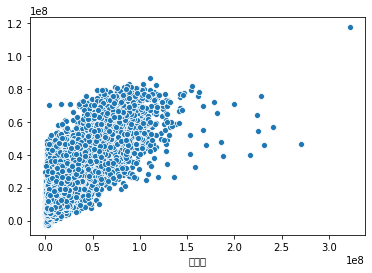

In [55]:
sns.scatterplot(_data['취급액'], model1.predict(X))

In [56]:
model1.score(X, _data['취급액'])

0.6565006412854497

## Random Forest

In [57]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth = 5, random_state = 0)
rf.fit(X, Y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestRegressor(max_depth=5, random_state=0)

In [ ]:
rf.score(X, Y)